### Feature Engineering and Selection:

- Objective: engineer new features and analyze their importance
- Method: first use Univariate tests to discard poor features (important when dealing with many features)
    Then, use recursive feature elimination and feature importances to get a feeling for ranking among features left


Dilemma: should we tune a model before feeding it to RFECV? Answer: first loosely tune models and then use regularized decision trees for a potentially more rigorouse answer:
            https://arxiv.org/pdf/1201.1587.pdf

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
os.listdir('../data/pickle_files/')

['.DS_Store',
 'final_df_pickle',
 'df_pickle_w_all_stats',
 'df_pickle',
 'df_pickle_w_time_stats']

In [5]:
#Loading final df from feature engineering notebook
final_df = pd.read_pickle('../data/pickle_files/final_df_pickle')
final_df = final_df.drop(columns = ['Date'])

In [6]:
def prep_df(df):
    y = df['duration']
    X = df.drop(df.filter(regex='y').columns, axis=1)
    X = X.drop(columns='duration')
    #Dropping features based on y
    X = X.drop(X.filter(regex="cust_acquisition_flag").columns, axis=1) 
    X = X.drop(X.filter(regex="cust_retention_flag").columns, axis=1)
    X = X.drop(X.filter(regex="prospect_conversion_flag").columns, axis=1)
    #Dropping linearly dependent features
    X = X.drop(columns = ['new_lead'])
    names = list(X.columns)
    return X, y, names

In [7]:
#loading df
X, y, names = prep_df(final_df)

Feature Importance:

Starting with an exploration of the most important features with univariate methods and RFE (with CV)

Univariate Feature Selection

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [9]:
def kbest(X,y, score_func, k):
    #Use f_regression or mutual_info_regression as scoring function
    test = SelectKBest(score_func=score_func, k=k)
    fit = test.fit(X, y)
    # summarize scores
    np.set_printoptions(precision=3)
    return sorted(list(zip(names,list(fit.scores_))), key=lambda tup:tup[1], reverse=True) 

In [10]:
best_cols = kbest(X,y, f_regression, 'all')

In [11]:
best_cols

[('duration-rolling-sum-10', 658.2322727850463),
 ('duration-rolling-avg-10', 658.2322727850224),
 ('duration-rolling-avg-30', 472.36586990655206),
 ('duration-rolling-sum-30', 472.365869906534),
 ('duration-rolling-avg-60', 465.1982134214848),
 ('duration-rolling-sum-60', 465.19821342142563),
 ('campaign', 212.8221977194653),
 ('campaign-rolling-sum-60', 162.57484634813886),
 ('campaign-rolling-avg-60', 162.5748463481367),
 ('FDI', 127.0960409440427),
 ('campaign-rolling-sum-30', 108.96647338777834),
 ('campaign-rolling-avg-30', 108.96647338777736),
 ('prev_subscr_flag', 83.11115440608762),
 ('Foreign exchange reserves', 80.87898740255453),
 ('Government debt', 78.98053221763733),
 ('prev_subscr_flag-rolling-avg-30', 78.91354586820017),
 ('prev_subscr_flag-rolling-sum-30', 78.91354586820017),
 ('campaign-rolling-sum-10', 75.00787008485212),
 ('campaign-rolling-avg-10', 75.00787008484477),
 ('previous-rolling-avg-60', 74.51842520207875),
 ('previous-rolling-sum-60', 74.51842520207872),

In [12]:
#among the top 70 indicators, many are economic indicators that are highly related to one another
#to avoid redundancy we will pick only the top 10 economic indicators
rfe_test1 = [i[0] for i in best_cols][:40]

In [13]:
X[rfe_test1].shape

(41188, 40)

Feature Importances Via Decision Tree Regression

In [14]:
def scale_noncat_only(X):
    
    X_temp_noncat = X.select_dtypes(exclude=['int8'])
    X_temp_noncat = X_temp_noncat.drop(X_temp_noncat.filter(regex="-categorical").columns, axis=1)
    
    
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = pd.DataFrame(scaler.transform(X_temp_noncat), columns = X_temp_noncat.columns)
    
    X = X_transformed.merge(X, left_index=True, right_index=True, how='inner', suffixes=('', '_rightdf'))
    X = X.drop(X.filter(regex="_rightdf").columns, axis=1)
    
    return X

In [15]:
X_test1 = X[rfe_test1]

In [16]:
X_test1 = scale_noncat_only(X_test1)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [17]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [18]:
def test_regression(X, y):
    lr = LinearRegression()
    lr.fit(X,y)
    scores = cross_val_score(lr,X,y,cv=10, scoring = 'r2')
    print('CV R2 : %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_test1,y, test_size = 0.20, random_state=4)

In [20]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [21]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [22]:
r2_score(y_test, model.predict(X_test))

0.016742790411616193

In [23]:
#Second test with less features
rfe_test2 = [i[0] for i in best_cols][:20]
X_test2 = X[rfe_test2]

In [24]:
X_test2 = scale_noncat_only(X_test2)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_test2,y, test_size = 0.20, random_state=4)

In [26]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [27]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [28]:
r2_score(y_test, model.predict(X_test))

0.016912919525384873

In [29]:
#loading df
X, y, names = prep_df(final_df)

In [30]:
#Third test with less features
rfe_test3 = [i[0] for i in best_cols][:70]
X_test3 = X[rfe_test3]

In [31]:
X_test3 = scale_noncat_only(X_test3)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_test3,y, test_size = 0.20, random_state=4)

In [33]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [34]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [35]:
r2_score(y_test, model.predict(X_test))

0.01978955349149969

Too many predictors are monthly while call duration depends on specific customer interaction

We give up regression methods as a way to predict call duration - will focus on autocorrelation models instead

In [37]:
from pandas.plotting import lag_plot

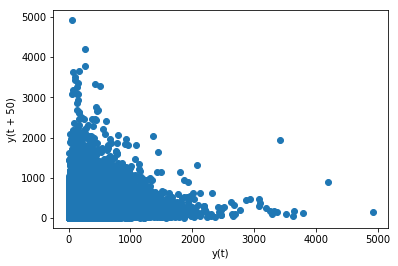

In [194]:
lag_plot(y, lag=50)

In [46]:
oldp_idx = X[X['old_prospect']==1].index

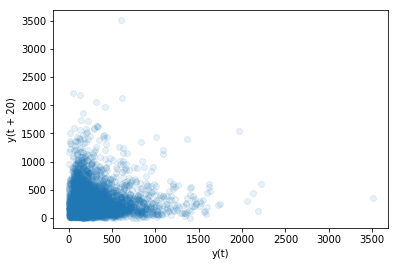

In [208]:
lag_plot(y[oldp_idx], alpha=0.1, lag=20)

In [ ]:
import matplotlib.pyplot as plt
lags = 9
columns = [y]
plt.figure(figsize=(12,12))

for i in range(1,(lags + 1)):
    columns.append(y.shift(i))

dataframe = pd.concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
                              
    columns.append('t-' + str(i)) 

dataframe.columns = columns 

for i in range(1,(lags + 1)):
    ax = plt.subplot(260 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'], y=dataframe['t-'+str(i)].values)
pyplot.show()

In [131]:
final_df = pd.read_pickle('../data/pickle_files/final_df_pickle')
##Old Prospect
oldp_idx = final_df[final_df['old_prospect']==1].index
y_oldprospect = y[oldp_idx]
##New Prospect
newp_idx = final_df[final_df['new_prospect']==1].index
y_newprospect = y[newp_idx]
##New Lead
newl_idx = final_df[final_df['new_lead']==1].index
y_newlead = y[newl_idx]

In [153]:
lag = 500
print(len(y)-lag)
print(len(y_oldprospect)-lag)
print(len(y_newprospect)-lag)
print(len(y_newlead)-lag)

40688
5125
20272
14291


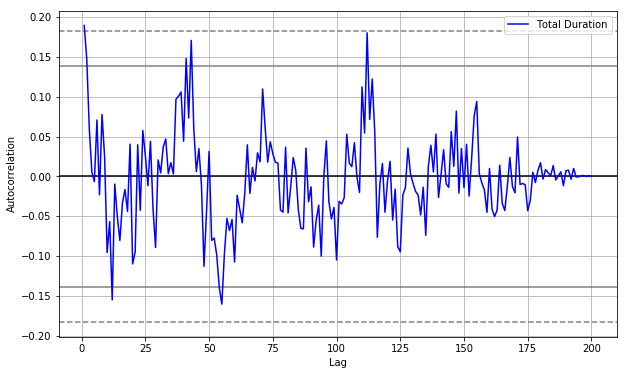

In [276]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10,6))

lag = 200
autocorrelation_plot(y[len(y)-lag:], ax=ax, color='blue', label='Total Duration')
#autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Old Prospet Duration')
#autocorrelation_plot(y_newprospect[len(y_newprospect)-lag:], ax=ax, color='orange', label='New Prospect Duration')
#autocorrelation_plot(y_newlead[len(y_newlead)-lag:], ax=ax, color='darkgreen', label='New Lead Duration')

plt.legend()
pyplot.show()

In [209]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [338]:
train, test = y[len(y)-200:len(y)-7], y[len(y)-7:]

In [339]:
model = AR(train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [340]:
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 14
Coefficients: const          276.724
L1.duration      0.197
L2.duration      0.117
L3.duration     -0.010
L4.duration     -0.010
L5.duration     -0.004
L6.duration      0.089
L7.duration     -0.095
L8.duration      0.100
L9.duration      0.031
L10.duration    -0.119
L11.duration    -0.011
L12.duration    -0.135
L13.duration     0.073
L14.duration    -0.047
dtype: float64


In [341]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 
for i in range(len(predictions)):
    print('predicted=%i, expected=%i'%(predictions.iloc[i], test.iloc[i])) 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=338, expected=281
predicted=334, expected=112
predicted=333, expected=334
predicted=366, expected=383
predicted=323, expected=189
predicted=370, expected=442
predicted=371, expected=239
Test RMSE: 115.771


/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


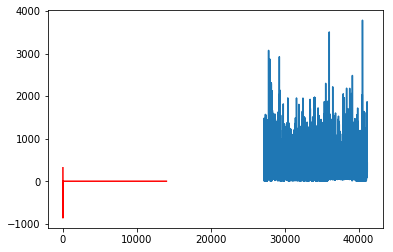

In [274]:
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

In [251]:
from statsmodels.tsa.arima_model import ARIMA

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/paulde

                             ARIMA Model Results                              
Dep. Variable:             D.duration   No. Observations:                  199
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -554.333
Method:                       css-mle   S.D. of innovations              3.913
Date:                Mon, 14 Jan 2019   AIC                           1122.667
Time:                        02:21:08   BIC                           1145.720
Sample:                             1   HQIC                          1131.997
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0193      0.085     -0.227      0.821      -0.186       0.147
ar.L1.D.duration    -0.7523      0.069    -10.852      0.000      -0.888      -0.616
ar.L2.D.duration    -0.5700 

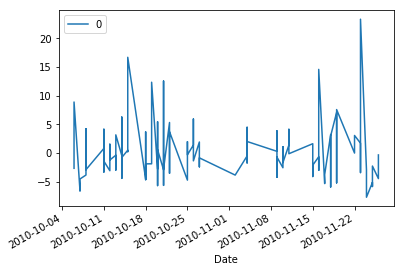

In [358]:
model = ARIMA(y_oldprospect[len(y_oldprospect)-lag:], order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
pyplot.show()

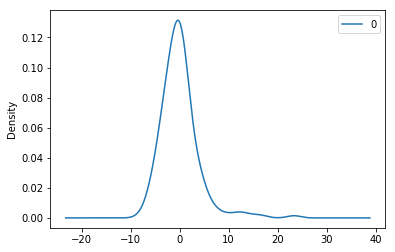

            0
count 199.000
mean    0.023
std     3.933
min    -7.725
25%    -2.360
50%    -0.388
75%     1.292
max    23.334


In [359]:
# density plot of residuals 
residuals.plot(kind='kde') 
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [ ]:
size = int(len(y) * 0.80)
train, test = y[0:size], y[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

predicted=332.919987, expected=65.000000
predicted=307.827322, expected=66.000000
predicted=296.980265, expected=34.000000
predicted=229.246262, expected=333.000000
predicted=252.391454, expected=128.000000
predicted=234.508157, expected=102.000000
predicted=122.351596, expected=400.000000
predicted=180.157773, expected=175.000000
predicted=194.788087, expected=69.000000
predicted=200.531177, expected=126.000000
predicted=166.853998, expected=285.000000
predicted=192.416820, expected=327.000000
predicted=230.462709, expected=168.000000
predicted=192.537115, expected=127.000000
predicted=184.423270, expected=314.000000
predicted=225.140037, expected=147.000000
predicted=226.217736, expected=472.000000
predicted=261.359550, expected=246.000000
predicted=246.400720, expected=213.000000
predicted=253.674157, expected=173.000000
predicted=260.473168, expected=220.000000
predicted=243.961746, expected=130.000000
predicted=240.204167, expected=299.000000
predicted=214.102765, expected=247.000

Test RMSE: 369.181


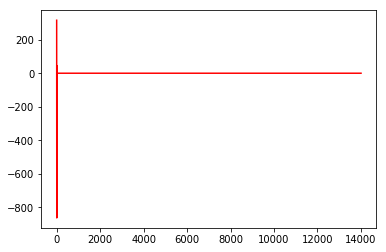

In [281]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

In [351]:
from __future__ import division
#Let's try dividing duration by 60 to predict minutes:
final_df = pd.read_pickle('../data/pickle_files/final_df_pickle')
##Old Prospect
oldp_idx = final_df[final_df['old_prospect']==1].index
y_oldprospect = y[oldp_idx]/60
y_oldprospect.index = final_df[final_df['old_prospect']==1].Date
##New Prospect
newp_idx = final_df[final_df['new_prospect']==1].index
y_newprospect = y[newp_idx]/60
y_newprospect.index = final_df[final_df['new_prospect']==1].Date
##New Lead
newl_idx = final_df[final_df['new_lead']==1].index
y_newlead = y[newl_idx]/60
y_newlead.index = final_df[final_df['new_lead']==1].Date

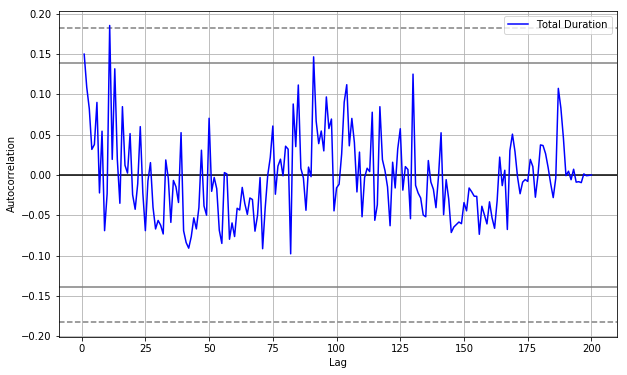

In [352]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10,6))

lag = 200
autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Total Duration')
#autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Old Prospet Duration')
#autocorrelation_plot(y_newprospect[len(y_newprospect)-lag:], ax=ax, color='orange', label='New Prospect Duration')
#autocorrelation_plot(y_newlead[len(y_newlead)-lag:], ax=ax, color='darkgreen', label='New Lead Duration')

plt.legend()
pyplot.show()

In [353]:
train, test = y_oldprospect[len(y_oldprospect)-50:len(y_oldprospect)-7], y_oldprospect[len(y_oldprospect)-7:]

In [354]:
model = AR(train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [355]:
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 10
Coefficients: const           4.991
L1.duration     0.004
L2.duration     0.138
L3.duration     0.206
L4.duration     0.162
L5.duration     0.209
L6.duration     0.028
L7.duration     0.030
L8.duration     0.314
L9.duration    -0.380
L10.duration   -0.454
dtype: float64


In [356]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 
for i in range(len(predictions)):
    print('predicted=%i, expected=%i'%(predictions.iloc[i], test.iloc[i])) 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=8, expected=4
predicted=12, expected=5
predicted=9, expected=3
predicted=11, expected=3
predicted=8, expected=8
predicted=9, expected=1
predicted=18, expected=3
Test RMSE: 8.074


/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
